# Multi-Class Classification using Deep Neural Network with Softmax

In previous experiments, only 2 classes of food take into classification. Now we expand the classes to 10 classses and assess the performance of models.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

import cv2
import glob
import shutil
from collections import Counter

from keras.callbacks import Callback
from keras.backend import clear_session

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import os
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print('TensorFlow version', tf.__version__)

Using TensorFlow backend.


TensorFlow version 2.3.1


In [24]:
# Set up path
base_dir = os.path.join(os.getcwd(), 'dataset')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [25]:
folder_list = [x[0] for x in os.walk(base_dir)][1:] # except the first one is parent folder
folder_list

['C:\\Users\\user\\Food_Classification\\dataset\\cheesecake',
 'C:\\Users\\user\\Food_Classification\\dataset\\chicken_curry',
 'C:\\Users\\user\\Food_Classification\\dataset\\chocolate_ice_cream',
 'C:\\Users\\user\\Food_Classification\\dataset\\french_toast',
 'C:\\Users\\user\\Food_Classification\\dataset\\fried_rice',
 'C:\\Users\\user\\Food_Classification\\dataset\\macarons',
 'C:\\Users\\user\\Food_Classification\\dataset\\nachos',
 'C:\\Users\\user\\Food_Classification\\dataset\\spaghetti_bolognese',
 'C:\\Users\\user\\Food_Classification\\dataset\\sushi',
 'C:\\Users\\user\\Food_Classification\\dataset\\test',
 'C:\\Users\\user\\Food_Classification\\dataset\\waffles']

In [26]:
classes_name = []
for i in folder_list:
    classes_name.append(os.path.basename(os.path.normpath(i)))
classes_name

['cheesecake',
 'chicken_curry',
 'chocolate_ice_cream',
 'french_toast',
 'fried_rice',
 'macarons',
 'nachos',
 'spaghetti_bolognese',
 'sushi',
 'test',
 'waffles']

In [30]:
not_data_folder = ['test','train', 'val']
classes = list()

for word in classes_name:   #for each word in line.split()
    if word not in not_data_folder:    #if a word isn't in line.split            
        classes.append(word) 

classes

['cheesecake',
 'chicken_curry',
 'chocolate_ice_cream',
 'french_toast',
 'fried_rice',
 'macarons',
 'nachos',
 'spaghetti_bolognese',
 'sushi',
 'waffles']

In [31]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.copy(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.copy(v, os.path.join(base_dir, 'val', cl))

cheesecake: 50 Images
chicken_curry: 50 Images
chocolate_ice_cream: 50 Images
french_toast: 50 Images
fried_rice: 48 Images
macarons: 50 Images
nachos: 50 Images
spaghetti_bolognese: 49 Images
sushi: 48 Images
waffles: 50 Images


In [36]:
batch_size = 50
IMG_SHAPE = 150

image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size, directory=train_dir, shuffle=True,target_size=(IMG_SHAPE,IMG_SHAPE))

Found 395 images belonging to 10 classes.


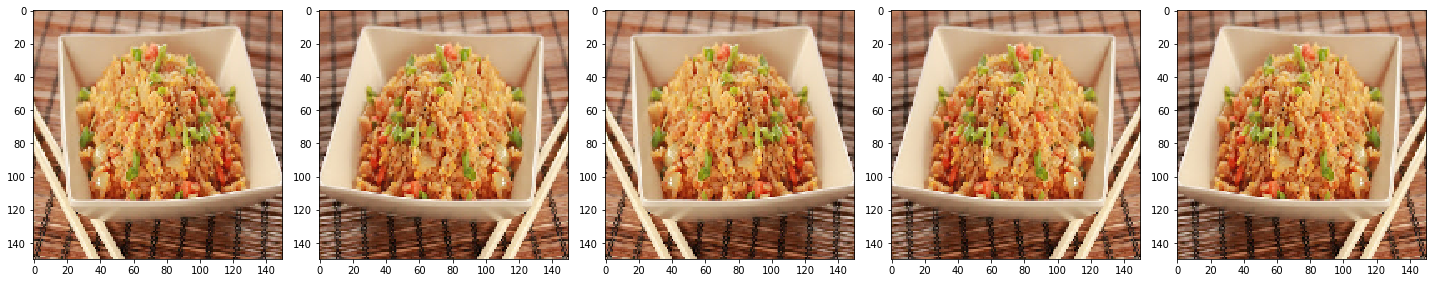

In [37]:
def plotImages(image_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip( image_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

augmented_images = [train_data_gen[1][0][0] for i in range(5)]
plotImages(augmented_images)

Found 395 images belonging to 10 classes.


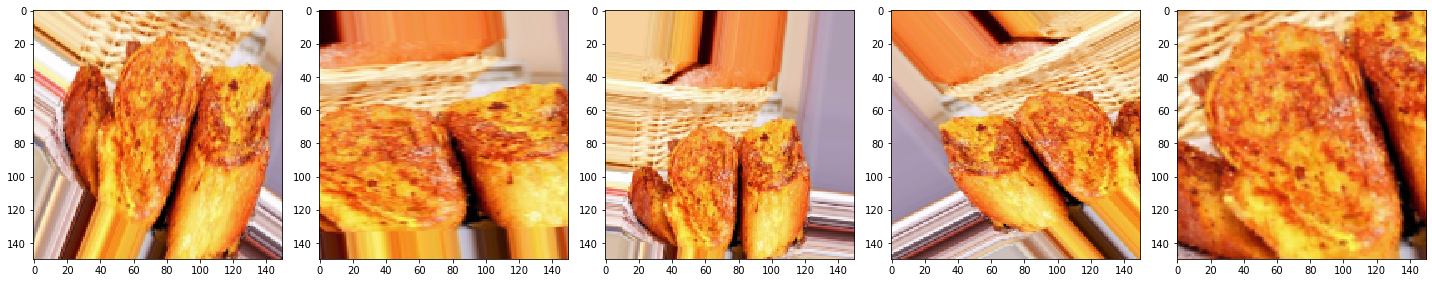

In [38]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [39]:
# validation data

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 100 images belonging to 10 classes.


In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_SHAPE,IMG_SHAPE,3)),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4320064   
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 4,329,674
Trainable params: 4,329,674
Non-trainable params: 0
_________________________________________________________________


In [41]:
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Epoch 1/100
8/8 [==============================] - 7s 864ms/step - loss: 14.5810 - accuracy: 0.1139 - val_loss: 10.8309 - val_accuracy: 0.1000
Epoch 2/100
8/8 [==============================] - 6s 758ms/step - loss: 6.4843 - accuracy: 0.1139 - val_loss: 3.8271 - val_accuracy: 0.0900
Epoch 3/100
8/8 [==============================] - 6s 771ms/step - loss: 3.6023 - accuracy: 0.1316 - val_loss: 2.7718 - val_accuracy: 0.1200
Epoch 4/100
8/8 [==============================] - 7s 840ms/step - loss: 2.6279 - accuracy: 0.1367 - val_loss: 2.5772 - val_accuracy: 0.1000
Epoch 5/100
8/8 [==============================] - 7s 830ms/step - loss: 2.6135 - accuracy: 0.1468 - val_loss: 2.4033 - val_accuracy: 0.1100
Epoch 6/100
8/8 [==============================] - 6s 764ms/step - loss: 2.5142 - accuracy: 0.1291 - val_loss: 2.3737 - val_accuracy: 0.1600
Epoch 7/100
8/8 [==============================] - 6s 768ms/step - loss: 2.4135 - accuracy: 0.1241 - val_loss: 2.3308 - val_accuracy: 0.1300
Epoch 8/100

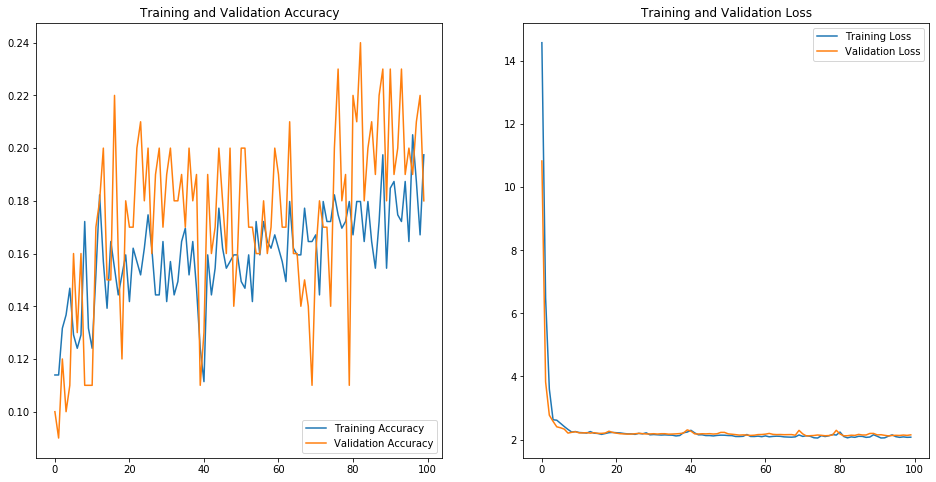

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
# read test data
import PIL
import PIL.Image
import pathlib

test_dir = pathlib.Path(test_dir)
image_count = len(list(test_dir.glob('*')))
print('Total test file: ',image_count)

Total test file:  20


In [84]:
def normalize(images):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images

In [98]:
test_image = list(test_dir.glob('*'))

test_array = []
y_pred = []

for test_url in test_image:
    test_img = tf.keras.preprocessing.image.load_img(test_url, target_size=(IMG_SHAPE,IMG_SHAPE))
    img_array = tf.keras.preprocessing.image.img_to_array(test_img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    norm_img_array = normalize(img_array)
    test_array.append(norm_img_array)
    pred = model.predict(norm_img_array)
    print('Prediction :', np.argmax(pred))
    y_pred.append(np.argmax(pred))
    score = tf.nn.softmax(pred[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence score."
        .format(classes[np.argmax(pred)], 100 * np.max(score))
    )
#     print('The actual file name is ', os.path.basename(os.path.normpath(test_url)))

Prediction : 1
This image most likely belongs to chicken_curry with a 10.47 percent confidence score.
Prediction : 5
This image most likely belongs to macarons with a 10.91 percent confidence score.
Prediction : 1
This image most likely belongs to chicken_curry with a 11.87 percent confidence score.
Prediction : 1
This image most likely belongs to chicken_curry with a 12.57 percent confidence score.
Prediction : 2
This image most likely belongs to chocolate_ice_cream with a 10.24 percent confidence score.
Prediction : 1
This image most likely belongs to chicken_curry with a 10.44 percent confidence score.
Prediction : 1
This image most likely belongs to chicken_curry with a 11.63 percent confidence score.
Prediction : 1
This image most likely belongs to chicken_curry with a 11.34 percent confidence score.
Prediction : 7
This image most likely belongs to spaghetti_bolognese with a 10.21 percent confidence score.
Prediction : 1
This image most likely belongs to chicken_curry with a 12.83

In [99]:
y_pred

[1, 5, 1, 1, 2, 1, 1, 1, 7, 1, 7, 1, 1, 1, 1, 1, 5, 7, 1, 1]

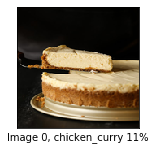

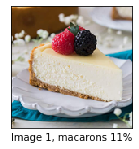

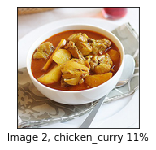

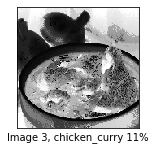

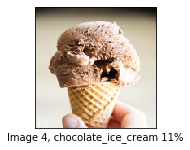

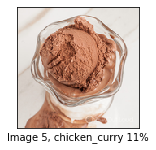

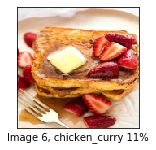

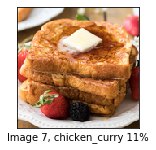

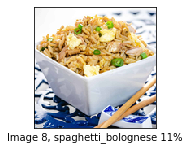

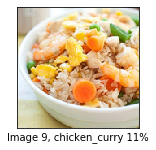

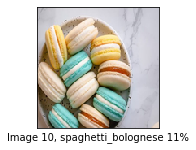

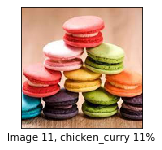

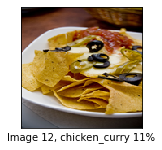

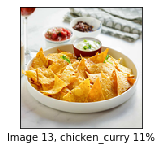

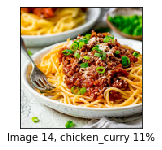

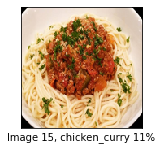

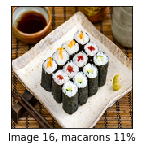

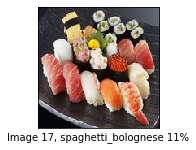

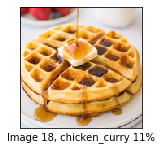

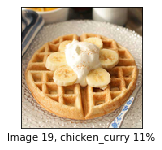

In [100]:
for i in range(len(test_image)):
    predictions_array, img = y_pred[i], test_image[i]

    img = PIL.Image.open(test_image[i])
    img = img.resize((IMG_SHAPE,IMG_SHAPE), PIL.Image.ANTIALIAS)
    
    num_rows = 5
    num_cols = 4
    
    plt.figure(figsize=(10, 20))
    plt.subplot(num_rows,num_cols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = int(predictions_array)


    plt.xlabel("Image {}, {} {:2.0f}%".format(i, classes[predicted_label],100*np.max(score)))

Notes Based on documentation from sklearn, the 'average' parameter is required for multiclass/multilabel targets. If None, the scores for each class are returned.

'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.

'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

In [101]:
from sklearn.metrics import f1_score

y_true = [0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9]

micro_f1_score = f1_score(y_true, y_pred, average='micro')
print('F1 score micro is ', micro_f1_score)
macro_f1_score = f1_score(y_true, y_pred, average='macro')
print('F1 score macro is ', macro_f1_score)
weighted_f1_score = f1_score(y_true, y_pred, average='weighted')
print('F1 score weighted is ', weighted_f1_score)

F1 score micro is  0.15
F1 score macro is  0.09166666666666666
F1 score weighted is  0.09166666666666666


In [102]:
print('Avg acc      :', np.mean(acc))
print('Avg val_acc  :', np.mean(val_acc))
print('Avg loss     :', np.mean(loss))
print('Avg val_loss :', np.mean(val_loss))

Avg acc      : 0.15962025344371797
Avg val_acc  : 0.17380000069737433
Avg loss     : 2.33848388671875
Avg val_loss : 2.293998577594757
